**AZ Watch** is a popular video streaming platform specialized in educational content, where creators publish online video tutorials and lessons about any topic, from speaking a new language to cooking to learning to play a musical instrument.

Their next goal is to leverage AI-driven solutions to analyze and make predictions about their subscribers and improve their marketing strategy around attracting new subscribers and retaining current ones. This project uses machine learning to predict subscribers likely to churn and find customer segments. This may help AZ Watch find interesting usage patterns to build subscriber personas in future marketing plans!

![Woman working on multiple screens](marketinganalytics.jpg)


The `data/AZWatch_subscribers.csv` **dataset** contains information about subscribers and their status over the last year:

|Column name|Description|
|-----------|-----------|
|`subscriber_id`|The unique identifier of each subscriber user|
|`age_group`|The subscriber's age group|
|`engagement_time`|Average time (in minutes) spent by the subscriber per session|
|`engagement_frequency`|Average weekly number of times the subscriber logged in the platform (sessions) over a year period|
|`subscription_status`|Whether the user remained subscribed to the platform by the end of the year period (subscribed), or unsubscribed and terminated her/his services (churned)|

Carefully observe and analyze the features in the dataset, asking yourself if there are any **categorical attributes** requiring pre-processing?

The subscribers dataset from the `data/AZWatch_subscribers.csv` file is already being loaded and split into training and test sets for you:

In [15]:
# Import the necessary modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

# Load the CSV file into a DataFrame
file_path = "data/AZWatch_subscribers.csv"
df = pd.read_csv(file_path)

# Separate predictor variables from class label
X = df.drop(['subscriber_id', 'subscription_status'], axis=1)
y = df['subscription_status'].map({'churned': 1, 'subscribed': 0})  # Map churned to 1, subscribed to 0 for logistic regression

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-Hot Encode the categorical attribute 'age_group'
X_train_prepared = pd.get_dummies(X_train, columns=['age_group'])
X_test_prepared = pd.get_dummies(X_test, columns=['age_group'])

In [16]:

# Train Logistic Regression Classifier
model = LogisticRegression()
model.fit(X_train_prepared, y_train)

# Get churn probability predictions for the test set
churn_probabilities = model.predict_proba(X_test_prepared)[:, 1]  # Probability of class 1 (churn)
X_test['churn_probability'] = churn_probabilities

# Rank subscribers by churn probability
X_test['churn_risk_rank'] = X_test['churn_probability'].rank(ascending=False)

# Display top 10 subscribers most likely to churn
high_risk_customers = X_test[['churn_probability', 'churn_risk_rank']].sort_values(by='churn_risk_rank').head(10)
print("\nTop 10 customers most likely to churn:\n", high_risk_customers)


Top 10 customers most likely to churn:
      churn_probability  churn_risk_rank
826           0.997465              1.0
764           0.995202              2.0
678           0.995076              3.0
559           0.993110              4.0
617           0.992310              5.0
635           0.991856              6.0
977           0.990827              7.0
314           0.988219              8.0
697           0.987957              9.0
312           0.987477             10.0


In [17]:
# CLASSIFICATION REPORT
# Print a classification report for model performance on test set
y_pred = model.predict(X_test_prepared)
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93       109
           1       0.91      0.92      0.92        91

    accuracy                           0.93       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.93      0.93      0.93       200



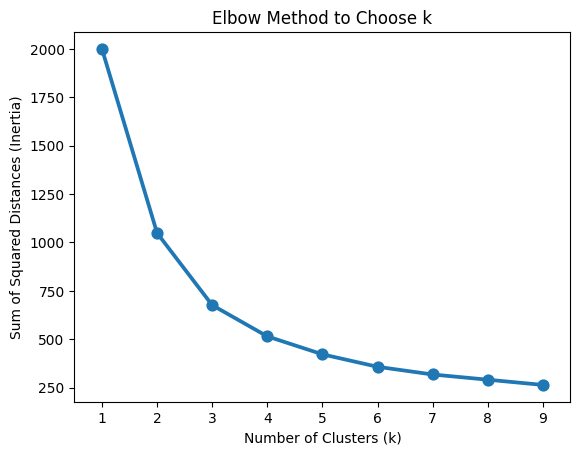

In [18]:
# CLUSTER ANALYSIS
# Drop categorical 'age_group' for clustering, but include it in the scaled data
segmentation = df.drop(['subscriber_id', 'subscription_status', 'age_group'], axis=1)

# Scale the data for clustering
scaler = StandardScaler()
segmentation_normalized = scaler.fit_transform(segmentation)

# Choose optimal k using the elbow method (repeated from the initial analysis)
sse = {}  # Sum of squared errors (distances) to each cluster
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(segmentation_normalized)
    sse[k] = kmeans.inertia_

# Plot elbow method results
plt.figure()
plt.title('Elbow Method to Choose k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [19]:
# Apply k-means clustering with 4 clusters (based on the elbow curve)
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster_id'] = kmeans.fit_predict(segmentation_normalized)

# Analyze average feature values and churn probabilities per cluster
# Merge churn probabilities into the original DataFrame
df = df.merge(X_test[['churn_probability']], left_index=True, right_index=True, how='left')

# Calculate average feature values and churn probability for each cluster
cluster_analysis = df.groupby('cluster_id').agg({
    'engagement_time': 'mean',
    'engagement_frequency': 'mean',
    'churn_probability': 'mean'
}).round(2)

print("\nCluster Analysis with Churn Probability:\n", cluster_analysis)


Cluster Analysis with Churn Probability:
             engagement_time  engagement_frequency  churn_probability
cluster_id                                                          
0                      5.80                 17.75               0.02
1                      3.65                  5.27               0.85
2                     10.14                 15.81               0.01
3                      7.99                  6.89               0.48
